In [2]:
%matplotlib inline

import os
import sys
import copy
import numpy as np
#np.seterr(over='ignore')
import scipy as sp

# filtering Astropy warnings
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

sys.path.append('../lib/')
from hdmclouds_v1 import *
from utils import *
from graph import *
from preprocessing import *
from gmr import *

from ipywidgets import interact, interactive, fixed, FloatSlider, IntSlider
import aplpy
import matplotlib
import matplotlib.pyplot as plt; plt.show()
matplotlib.rcParams.update({'font.size': 13})

from pycupid import *

from sklearn.cluster import DBSCAN,MeanShift,AffinityPropagation

save_path = "/Users/martin/Dropbox/Aplicaciones/ShareLaTeX/HDMC-v1/figures/"


from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.exceptions import AstropyWarning

def load_data(fits_path):
    hdu = fits.open(fits_path)[0]
    data = hdu.data
    wcs = WCS(hdu.header)

    if data.ndim>3:
        # droping out the stokes dimension
        data = np.ascontiguousarray(data[0])
        wcs = wcs.dropaxis(3)

        if data.shape[0]==1:
            # in case data is not a cube but an image
            data = np.ascontiguousarray(data[0])
            wcs = wcs.dropaxis(2)
    
    # in case NaN values exist on data
    mask = np.isnan(data)
    if np.any(mask): data = ma.masked_array(data, mask=mask)

    return data,wcs,hdu

# function to visualize points clusters
def points_clusters(data, points, labels, wcs=None):
    x_scale = data.shape[0]-1
    y_scale = data.shape[1]-1
    fig = plt.figure(figsize=(10,10))
    if wcs is not None: fig.gca(projection=wcs)
    plt.imshow(data, cmap=plt.cm.gray_r)

    colors = plt.cm.gist_rainbow(np.linspace(0., 1., np.max(labels)+2))

    for i,label in enumerate(range(-1, np.max(labels)+1)):
        _points = points[labels==label]
        plt.scatter(_points[:,1]*y_scale, _points[:,0]*x_scale, s=20, 
                facecolor=colors[i], lw=0, alpha=0.9, label="{0}-th cluster".format(label))
    plt.legend(loc="best", prop={'size': 10})  
    plt.grid()
    ax = plt.gca()
    ax.invert_yaxis()
    if wcs is not None:
        plt.xlabel(umap[wcs.axis_type_names[0]])
        plt.ylabel(umap[wcs.axis_type_names[1]])
    plt.show()

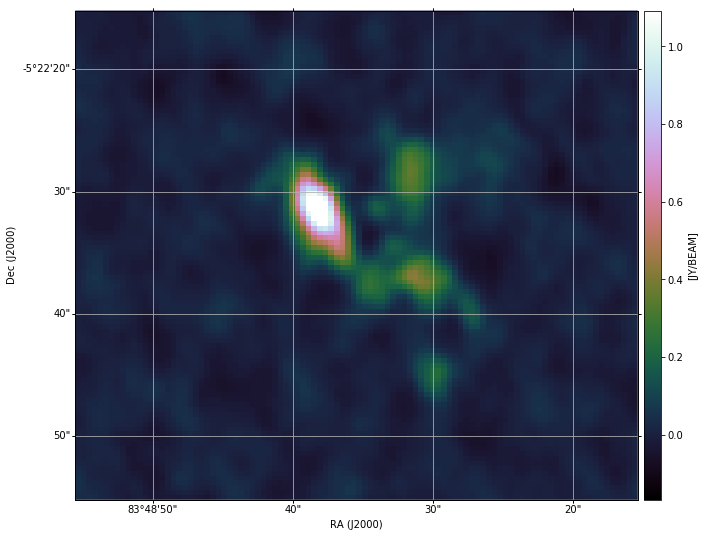

In [5]:
fits_path = '../data/images/Orion.cont.image.fits'

data,wcs,hdu = load_data(fits_path)
#data,wcs,hdu,freq = load_data(fits_path)
base_level = estimate_rms(data)
image_plot(data, wcs=wcs, unit=hdu.header["BUNIT"])

[INFO] Number of usable pixels: 749


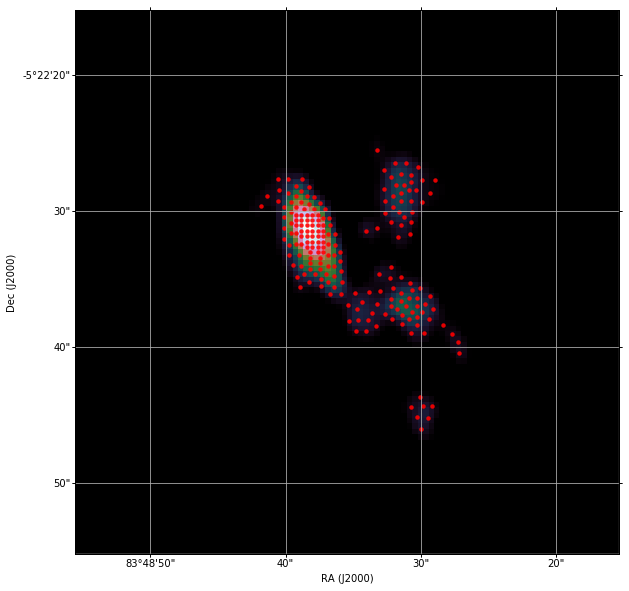

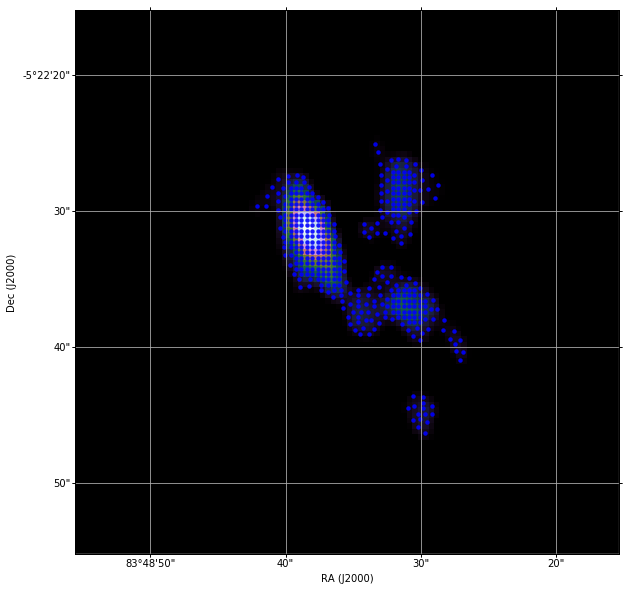

In [6]:
hdmc = HDMClouds(data, back_level=0.089, wcs=wcs, verbose=True, n_center=200)

#### DBSCAN

In [25]:
points = np.vstack([hdmc.xc, hdmc.yc]).T

db = DBSCAN(eps=0.04, min_samples=5, n_jobs=-1)
db.fit(points)

DBSCAN(algorithm='auto', eps=0.04, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=-1, p=None)

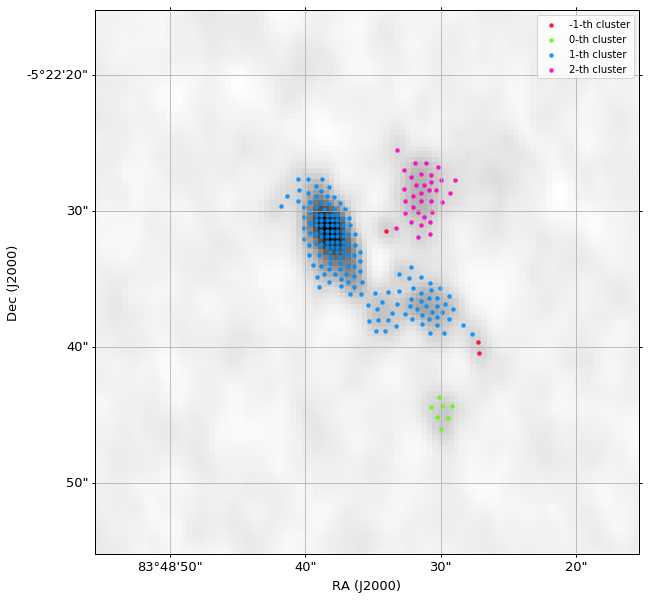

In [26]:
points_clusters(data, points, db.labels_, wcs=wcs)

#### MeanShift

In [93]:
points1 = np.vstack([hdmc.xe, hdmc.ye]).T
points2 = np.vstack([hdmc.xc, hdmc.yc]).T

ms = MeanShift(bandwidth=0.095, cluster_all=False)
ms.fit(points1)

MeanShift(bandwidth=0.095, bin_seeding=False, cluster_all=False,
     min_bin_freq=1, n_jobs=1, seeds=None)

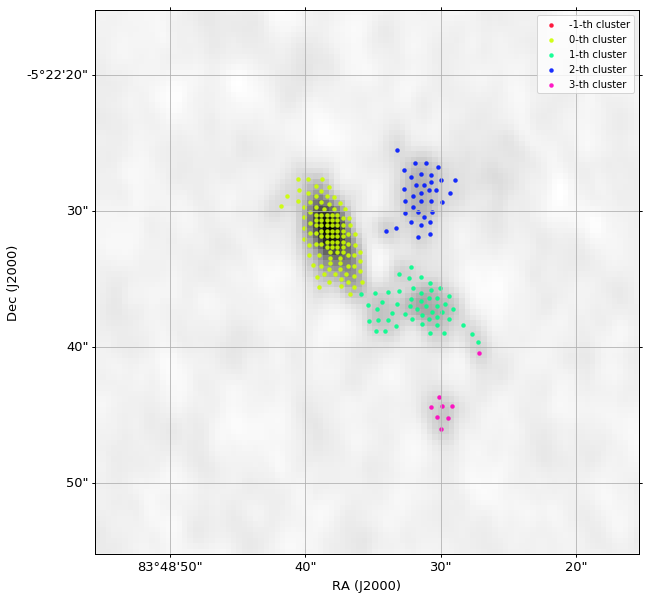

In [94]:
labels = ms.predict(points2)

points_clusters(data, points2, labels, wcs=wcs)

#### AffinityPropagation

In [99]:
af = AffinityPropagation(damping=0.9)
af.fit(points)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.9, max_iter=200, preference=None, verbose=False)

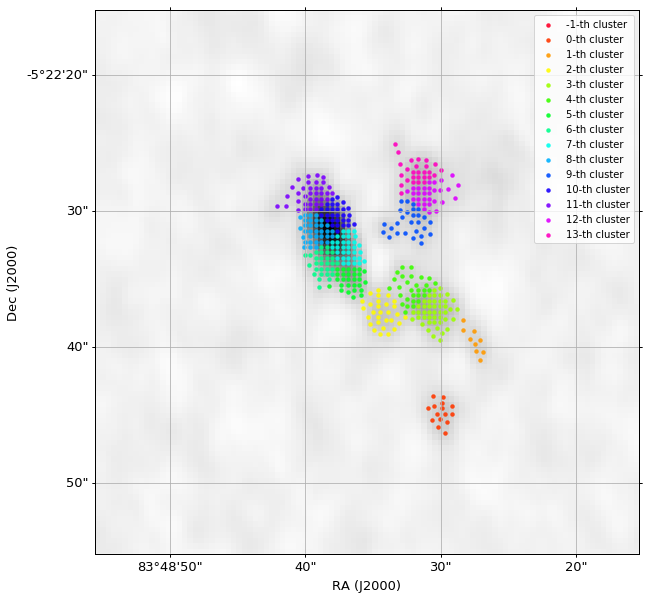

In [100]:
points_clusters(data, points, af.labels_, wcs=wcs)

***
***

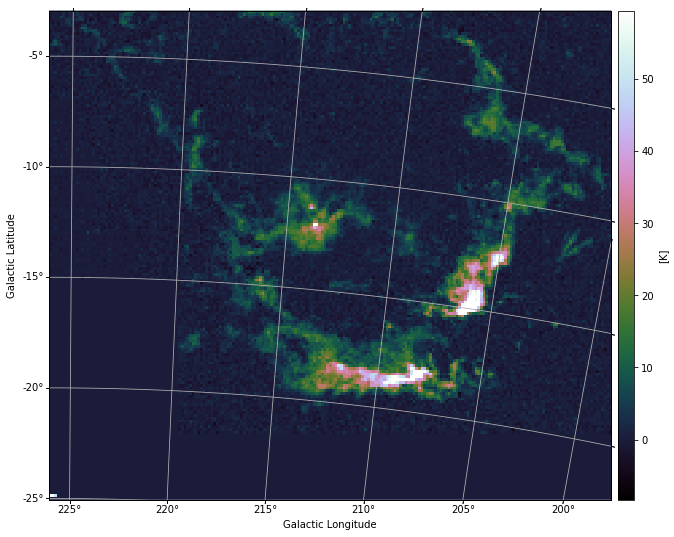

In [12]:
fits_path = '../data/SCIMES/orion_12CO_mom0.fits'

data,wcs,hdu = load_data(fits_path)
#data,wcs,hdu,freq = load_data(fits_path)
base_level = estimate_rms(data)
image_plot(data, wcs=wcs, unit=hdu.header["BUNIT"])

[INFO] Number of usable pixels: 6622
(6622, 50)
(600, 18)


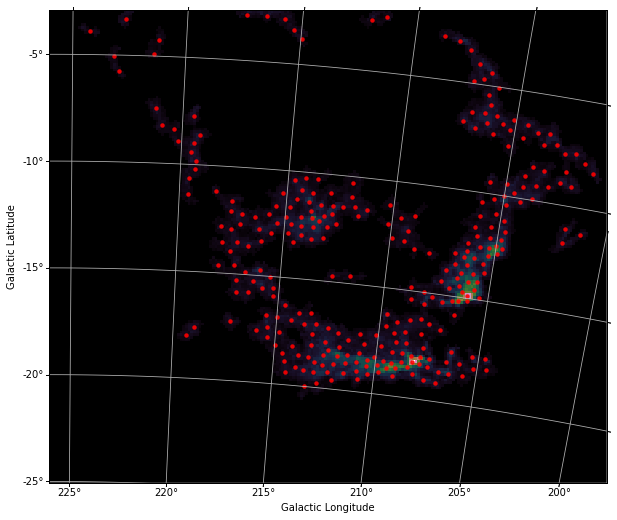

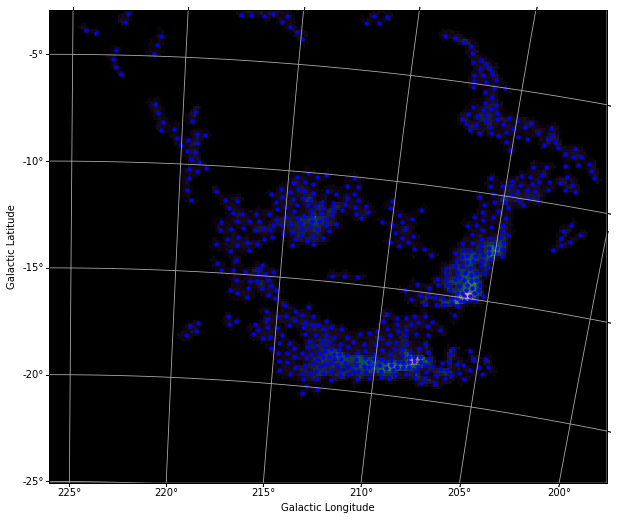

In [13]:
hdmc = HDMClouds(data, back_level=1.00798, wcs=wcs, verbose=True, n_center=300)

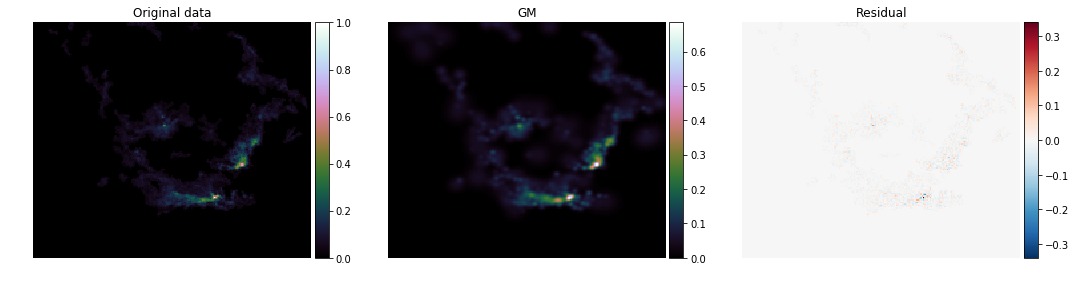

RESIDUAL STATS
RMS of residual: 0.00756534200645458
Inf norm of residual: 0.33976576712905915
Variance of residual: 5.723438150165088e-05
Normalized flux addition: 0.08439389484479477
Normalized flux lost: 0.08406978604553124


(0.00756534200645458,
 5.723438150165088e-05,
 0.08439389484479477,
 0.08406978604553124)

In [15]:
#hdmc.build_gmr()
#hdmc.get_residual_stats()

***

#### DBSCAN

In [111]:
points1 = np.vstack([hdmc.xe, hdmc.ye]).T
points2 = np.vstack([hdmc.xc, hdmc.yc]).T

In [112]:
db = DBSCAN(eps=0.04, min_samples=5, n_jobs=-1)
db.fit(points2)

DBSCAN(algorithm='auto', eps=0.04, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=-1, p=None)

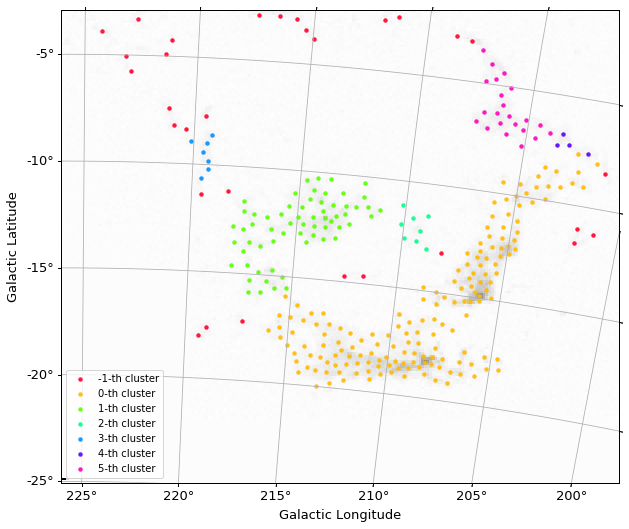

In [114]:
points_clusters(data, points2, db.labels_, wcs=wcs)

#### MeanShift

In [115]:
points1 = np.vstack([hdmc.xe, hdmc.ye]).T
points2 = np.vstack([hdmc.xc, hdmc.yc]).T

ms = MeanShift(bandwidth=0.1, cluster_all=False)
ms.fit(points1)

MeanShift(bandwidth=0.1, bin_seeding=False, cluster_all=False, min_bin_freq=1,
     n_jobs=1, seeds=None)

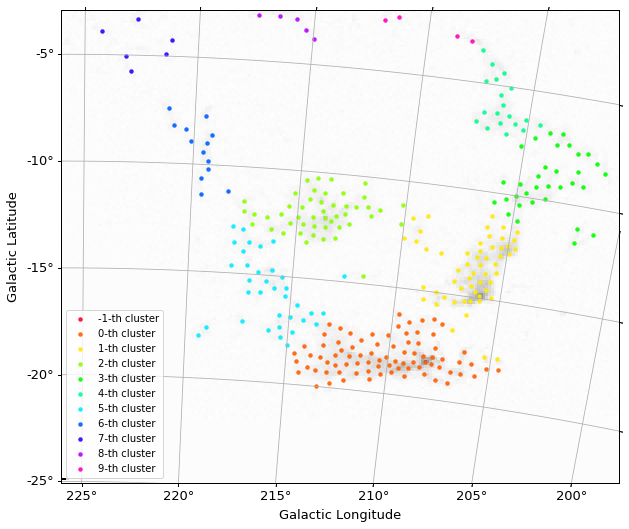

In [116]:
labels = ms.predict(points2)
points_clusters(data, points2, labels, wcs=wcs)

#### AffinityPropagation

In [117]:
af = AffinityPropagation(damping=0.5)
af.fit(points2)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False)

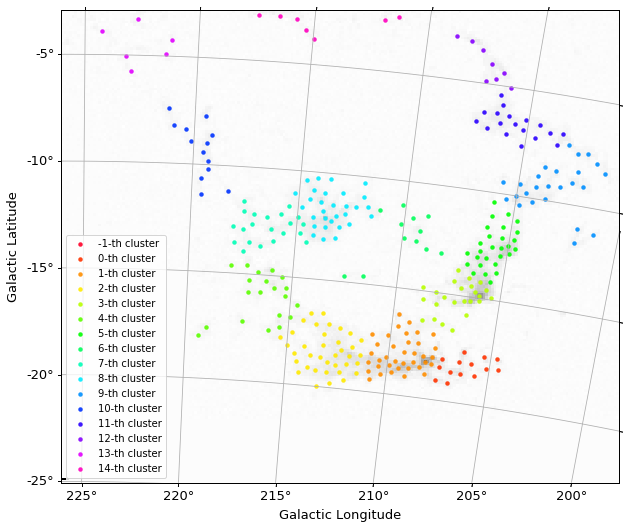

In [119]:
points_clusters(data, points2, af.labels_, wcs=wcs)

## Agglomeration over the very-first IG

In [62]:
data = np.copy(data)
back_level=1.00798
mask = compute_mask(data, back_level)
data[mask] -= back_level
vmin = data[mask].min(); vmax = data[mask].max()
data -= vmin
data /= vmax-vmin
data[~mask] = 0

# generating the data function
_x = np.linspace(0., 1., data.shape[0]+1, endpoint=True)
_y = np.linspace(0., 1., data.shape[1]+1, endpoint=True)
_xe = np.asarray( [(_x[i]+_x[i+1])/2 for i in range(len(_x)-1)] )
_ye = np.asarray( [(_y[i]+_y[i+1])/2 for i in range(len(_y)-1)] )
Xe,Ye = np.meshgrid(_xe, _ye, sparse=False, indexing='ij')

# initial w
w = (data[mask]).astype(np.float64)
xc = Xe[mask]; yc = Ye[mask]
mu = np.vstack([xc,yc]).T
k = 0.25
pix_lenght = sum([1./data.shape[0], 1./data.shape[1]])/2.
sig = (pix_lenght/(2.*k))*np.ones(w.shape[0])

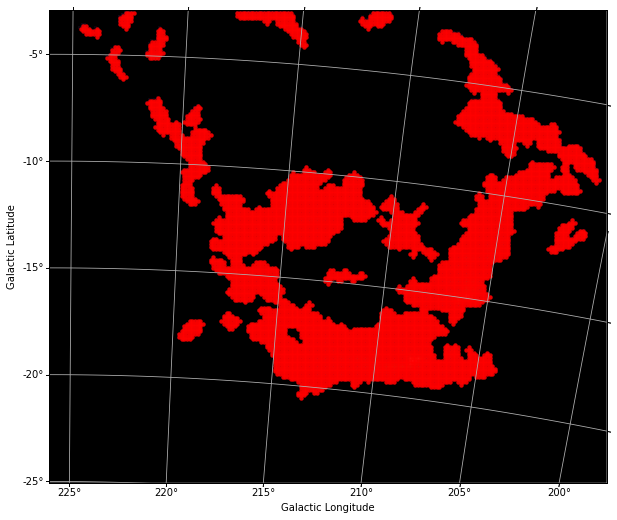

In [63]:
points_plot(data, points=mu, color="red", wcs=wcs)

#### DBSCAN

In [140]:
min(1/177.,1/209.)

0.004784688995215311

In [139]:
1/209.

0.004784688995215311

In [153]:
db = DBSCAN(eps=0.01, min_samples=5, n_jobs=-1)
db.fit(mu)

DBSCAN(algorithm='auto', eps=0.01, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=-1, p=None)

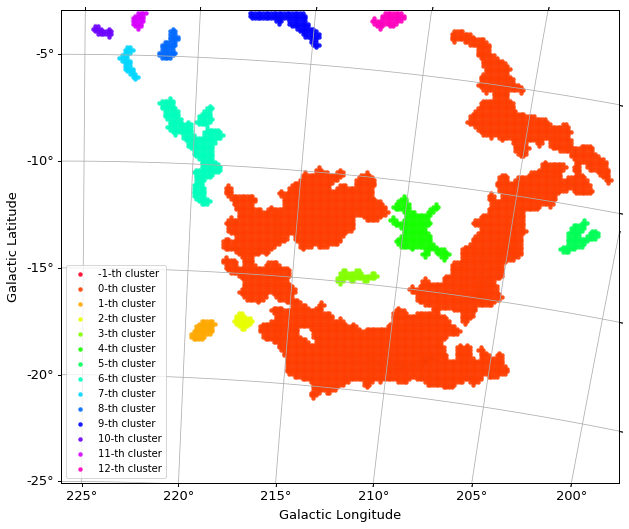

In [154]:
points_clusters(data, mu, db.labels_, wcs=wcs)

#### MeanShift

In [132]:
#ms = MeanShift(bandwidth=0.1, cluster_all=False)
ms = MeanShift()
ms.fit(mu)

MeanShift(bandwidth=None, bin_seeding=False, cluster_all=True, min_bin_freq=1,
     n_jobs=1, seeds=None)

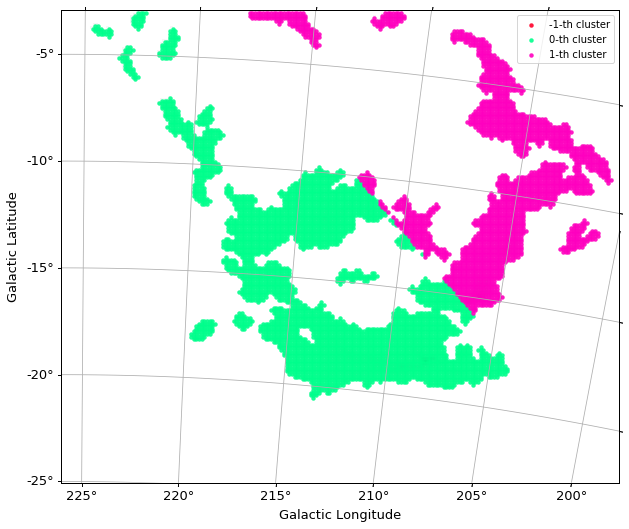

In [133]:
points_clusters(data, mu, ms.labels_, wcs=wcs)

#### AffinityPropagation

In [134]:
af = AffinityPropagation(damping=0.5)
af.fit(mu)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.5, max_iter=200, preference=None, verbose=False)

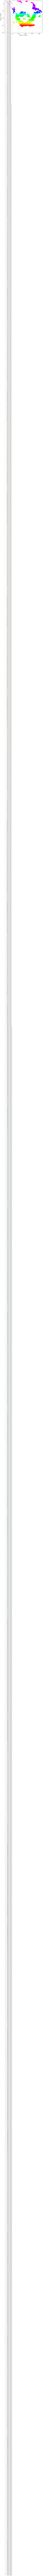

In [135]:
points_clusters(data, mu, af.labels_, wcs=wcs)

***

# A different approach

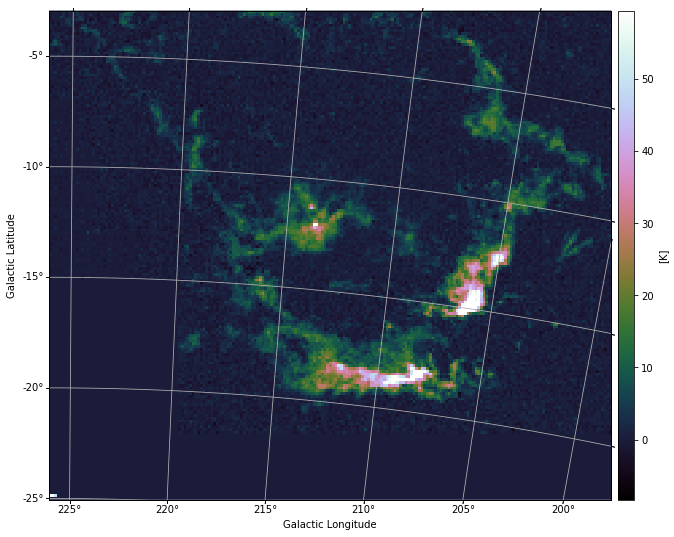

In [78]:
fits_path = '../data/SCIMES/orion_12CO_mom0.fits'

data,wcs,hdu = load_data(fits_path)
#data,wcs,hdu,freq = load_data(fits_path)
base_level = estimate_rms(data)
image_plot(data, wcs=wcs, unit=hdu.header["BUNIT"])

[INFO] Number of usable pixels: 6622
(6622, 50)
(600, 18)


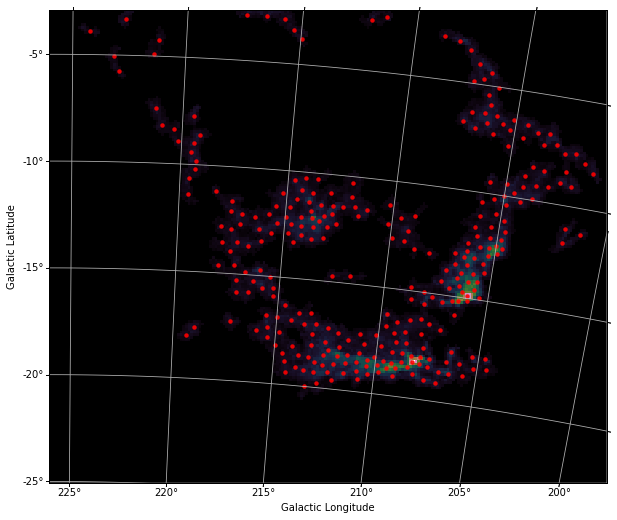

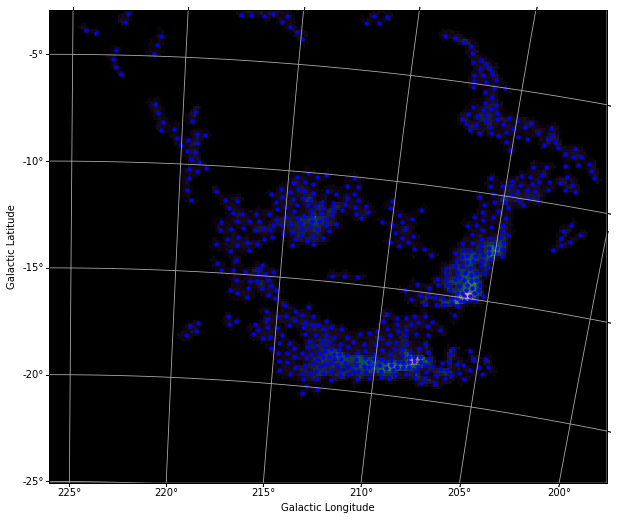

In [16]:
hdmc = HDMClouds(data, back_level=1.00798, wcs=wcs, verbose=True, n_center=300)

In [29]:
w,sig = hdmc.get_params_mapped()

xc,yc = hdmc.xc,hdmc.yc
mu = np.vstack([xc,yc]).T

d = mu.shape[1]
cov = np.asarray( [(_sig**2)*np.identity(d) for _sig in sig] )

N = len(w)

In [31]:
# computing the dissimilarity matrix
diss_matrix = np.empty((N,N))

for i in range(N):
    for j in range(N):
        diss_matrix[i,j] = KLdiv(w[i],mu[i],cov[i],w[j],mu[j],cov[j])     

In [32]:
diss_matrix.min()

0.0

In [33]:
diss_matrix.max()

2.931757338303879

In [49]:
affinity_matrix = 1-diss_matrix

afmin = affinity_matrix.min()
afmax = affinity_matrix.max()

affinity_matrix -= afmin
affinity_matrix /= afmax-afmin

In [50]:
from sklearn.cluster import SpectralClustering

In [59]:
sc = SpectralClustering(n_clusters=10, affinity="precomputed")

In [60]:
sc.fit(affinity_matrix)

SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=10, n_init=10, n_jobs=1,
          n_neighbors=10, random_state=None)

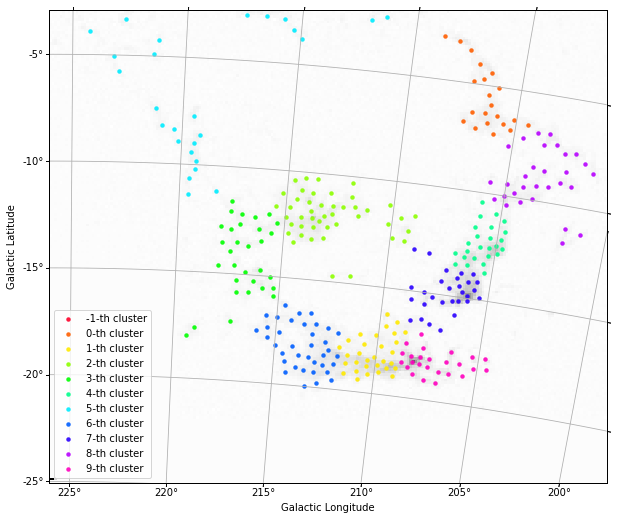

In [61]:
points_clusters(data, mu, sc.labels_, wcs=wcs)

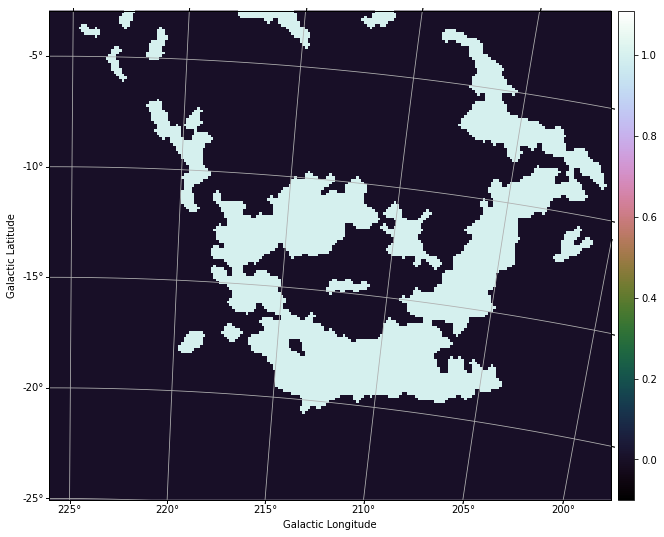

In [65]:
image_plot(mask, wcs=wcs)

In [67]:
from skimage.morphology import binary_erosion, binary_dilation, binary_opening, binary_closing
from skimage.morphology import square, disk, cube, ball

In [69]:
# structuring elements
disk1 = disk(1)
square2 = square(2)

In [75]:
mask = binary_opening(mask, selem=disk1)

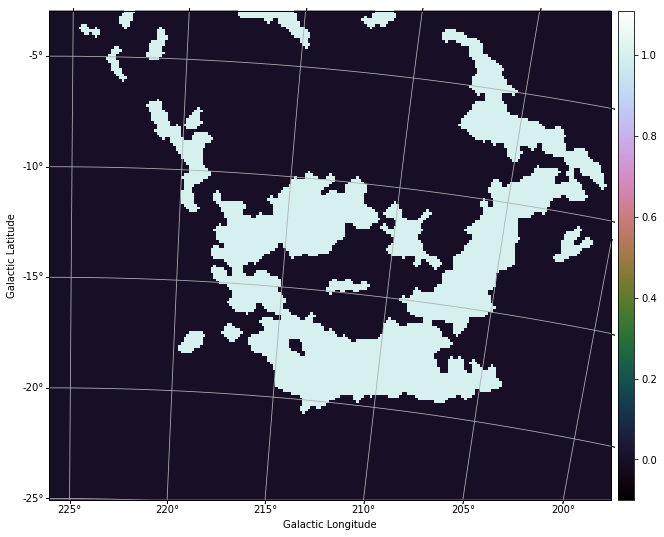

In [76]:
image_plot(mask, wcs=wcs)